In [1]:
from aeda import *
from eda import *
from pororomt import *

import pandas as pd
from pororo import Pororo
from konlpy.tag import Komoran, Kkma, Okt, Hannanum

import seaborn as sns
import warnings
import random
import matplotlib.pyplot as plt
import re

warnings.filterwarnings(action='ignore')
random.seed(42)

# 목차
- 형태소분석기 -> Okt로 조사 제거
- no_answer 증강
- EDA(Easy Data Augmentation)
- AEDA(An Easier Data Augmentation)
- Back Translation(일본,영어,중국)
--- 

`데이터`

In [2]:
df=pd.read_csv('../data/raw_data/origin_data.csv')

`Pororo NER`

In [3]:
ner = Pororo(task="ner", lang="ko")

`토크나이저`

In [4]:
from transformers import AutoModel, AutoTokenizer

MODEL_NAME = "klue/roberta-large"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# 형태소분석기 -> Okt로 조사제거

- [Okt 품사관련 참고링크](https://datascienceschool.net/03%20machine%20learning/03.01.02%20KoNLPy%20%ED%95%9C%EA%B5%AD%EC%96%B4%20%EC%B2%98%EB%A6%AC%20%ED%8C%A8%ED%82%A4%EC%A7%80.html) 
- 제거해야할것 : Josa
    - Puncuation은 "?" 때문에 안됨

In [5]:
komoran = Komoran()
kkma = Kkma()
okt = Okt()
hannanum=Hannanum()

class List(list): 
    def __str__(self): 
        return "[" + ", ".join(["%s" % x for x in self]) + "]"
    
sentence='제178회 완주군의회 임시회 회기는 언제로 결정됐어?'

# print(List(komoran.morphs(sentence)))
# print(List(hannanum.morphs(sentence)))
# print(List(okt.morphs(sentence)))
# print(List(kkma.morphs(sentence)))
# print("------------")
# print(komoran.morphs(sentence))
# print(hannanum.morphs(sentence))
# print(okt.morphs(sentence))
# print(kkma.morphs(sentence))

In [6]:
df_del_josa=pd.read_csv('../data/raw_data/origin_data.csv')

new=[]
for i in range(len(df_del_josa)):
    for j in range(len(okt.pos(df_del_josa['question'][i]))):
        new.append(okt.pos(df_del_josa['question'][i])[j][1])

print(f"데이터 프레임 안의 품사 : {list(set(new))}")

데이터 프레임 안의 품사 : ['Adverb', 'Adjective', 'Suffix', 'Verb', 'Conjunction', 'Determiner', 'Alpha', 'Josa', 'Noun', 'Foreign', 'Number', 'Modifier', 'Punctuation']


In [7]:
del_josa=[]
for i in range(len(df_del_josa)):
    okt_pos_list=okt.pos(df_del_josa['question'][i])
    tmp_list=[]
    for j in range(len(okt_pos_list)):
        if okt_pos_list[j][1]!='Josa':
            tmp_list.append(okt_pos_list[j][0])
    del_josa.append(' '.join(tmp_list))

df_del_josa['question']=del_josa

In [8]:
df_del_josa.to_csv("../data/raw_data/origin_data_del_josa.csv", mode='w', index=False)

# EDA
- eda.py 수정 -> RD사용안하고, num_aug =5 -> set으로 중복제거 ->리스트 안의 1개만 가져오기
- 사용 : EDA(sentence)
# 네가지
- SR: Synonym Replacement, 특정 단어를 유의어로 교체
- RI: Random Insertion, 임의의 단어를 삽입
- RS: Random Swap, 문장 내 임의의 두 단어의 위치를 바꿈
- RD: Random Deletion: 임의의 단어를 삭제(X)

In [9]:
df_eda=pd.read_csv('../data/train.csv')

In [10]:
why_list=list(df_eda[df_eda['category']==5].index)
what_list=list(df_eda[df_eda['category']==6].index)

why_df=df_eda.iloc[why_list]
what_df=df_eda.iloc[what_list]

what_qu_list=list(what_df['question'])
why_qu_list=list(why_df['question'])

what_eda_qu_list=list(map(EDA,what_qu_list))
why_eda_qu_list=list(map(EDA,why_qu_list))

what_df.to_csv("../data/raw_data/what_data.csv", mode='w', index=False)
why_df.to_csv("../data/raw_data/why_data.csv", mode='w', index=False)

In [11]:
what_df=pd.read_csv('../data/raw_data/what_data.csv')
why_df=pd.read_csv('../data/raw_data/why_data.csv')

what_df['question']=what_eda_qu_list
why_df['question']=why_eda_qu_list

new_eda_df=pd.concat([df_eda,what_df,why_df])

# 인덱스 초기화
new_eda_df.index=[i for i in range(len(new_eda_df))]
new_eda_df=new_eda_df.sample(frac=1,random_state=42).reset_index(drop=True)

In [12]:
new_eda_df.to_csv("../data/train.csv", mode='w', index=False)

# AEDA
- aeda.py수정 -> DATASETS사용X
- 사용 : insert_punctuation_marks(sentence)

In [13]:
df_aeda=pd.read_csv('../data/raw_data/origin_data.csv')

In [14]:
aeda_list=[]
for i in range(len(df_aeda)):
    aeda_list.append(insert_punctuation_marks(df_aeda['question'][i]))
    
df_aeda['question']=aeda_list

In [15]:
df_aeda.to_csv("../data/raw_data/origin_data_aeda.csv", mode='w', index=False)

# Back Translation
- 참고 : https://kakaobrain.github.io/pororo/seq2seq/mt.html
- 성능을 위해서 fast 사용 X  
![score](https://user-images.githubusercontent.com/46811558/170887191-bca7b5c0-fa84-4acf-8fb5-14560d6bb706.png)

# 일본어로 진행 

In [ ]:
qu_list=list(df['question'])
bt_qu_list=[]

for i in range(len(qu_list)):
    bt_qu_list.append(back_translation(qu_list[i],language='ja'))

In [ ]:
new_df=pd.read_csv('../data/raw_data/origin_data.csv')
new_df['question']=bt_qu_list
new_df.to_csv('../data/raw_data/origin_data_ja_bt.csv',index=False)

In [ ]:
new_df['context'][0]

# 비교

In [34]:
sen='제178회 완주군의회 임시회 회기는 언제로 결정됐어?'

print(f"원문 : {sen}")
print("----------------------------------")
print(f"EDA : {EDA(sen)}")
print("----------------------------------")
print(f"AEDA : {insert_punctuation_marks(sen)}")
print("----------------------------------")
print(f"Back Translation")
print(f"영어 : {back_translation(sen,language='en')} ")
print(f"일본어 : {back_translation(sen,language='ja')} ")
print(f"중국어 : {back_translation(sen,language='zh')} ")
print("----------------------------------")

원문 : 제178회 완주군의회 임시회 회기는 언제로 결정됐어?
----------------------------------
EDA : 제178회 완주군의회 임시회 회기는 결정됐어? 언제로
----------------------------------
AEDA : , 제178회 완주군의회 임시회 회기는 언제로 결정됐어?
----------------------------------
Back Translation
영어 : 완주군의회 제178회 임시회가 언제 결정됐나요? 
일본어 : 제178회 완주군 의회의 임시회의는 언제로 정해졌니? 
중국어 : 군사위원회의 임시 회의가 언제 결정되었는지 
----------------------------------


---
# No_answer 증강
- `haystack_preprocess.ipynb`로 origin_data.csv 만들기 -> `data_split.ipynb`로 split한 train사용한 후에 적용해야 함!
- No_answer을 잘 못 맞추는 경향이 발견되어 증강 적용
- 코드 적용 도중, origin_data.csv를 전처리할 때, haystack_preprocess.ipynb가 no_answer를 " "가 아닌 ""로 적용되는 코드오류발견
- 오류는 strip을 if문 밖에서 적용했기 때문-> 코드 수정, 데이터 수정 및 공유 하면서 오류 바로잡음

## 정규표현식으로 수정 : 제(n)회 -> 제(n+10)회

In [35]:
def multiple10(m):        
    n = m.group()
    i = int(n[1:len(n)-1])+10
    return "제"+str(i)+"회"
def multiple10_sentence(sentence):
    return re.sub(r'제[0-9]+회', multiple10, sentence)

In [36]:
df_no=pd.read_csv('../data/train.csv')
df_no['answers']=df_no['answers'].apply(lambda x:eval(x))  

## no_answer만 살펴보기 & 유형별 분포

In [37]:
no_list=[]
for i in range(len(df_no)):
    if len(df_no['answers'][i]['text'])==1 and df_no['answers'][i]['text']==" ":
        no_list.append(i)
no_df=df_no.iloc[no_list]

question_mark_dict={1:'1 : When(term)',
                    2:'2 :When(date)',
                    3:'3 : Who(action)',
                    4:'4 : Who(role)',
                    5:'5 : Why(action)',
                    6:'6 : What(indicator)',
                    7:'7 : What(conference)'}

category_list=list(no_df['category'])

for i in range(len(category_list)):
    for key in question_mark_dict.keys():
        if category_list[i]==key:
            category_list[i]=question_mark_dict[key]

no_df['category']=category_list

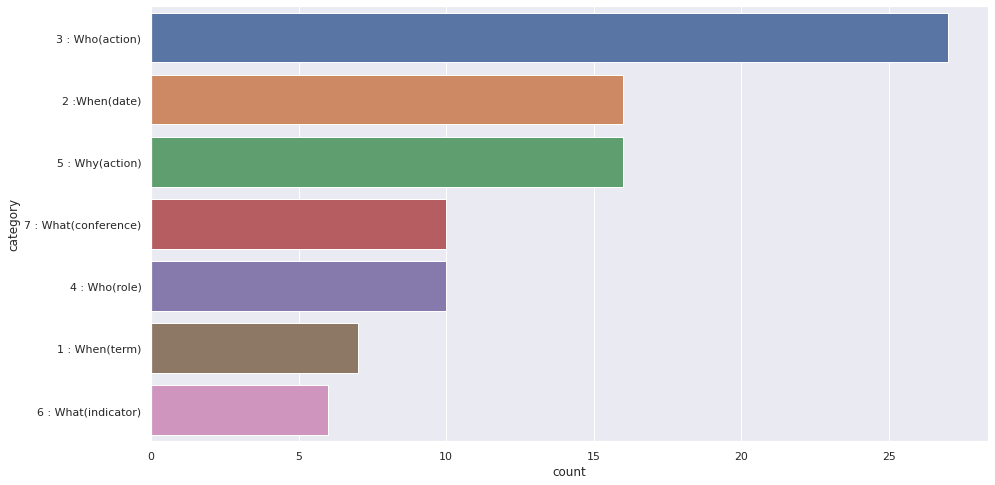

In [38]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(y='category', data=no_df, order=no_df['category'].value_counts().index)

# no_answer 증강 -> EDA의 유형별 분포를 맞춰주기 위해, 부족한 부분 일본어역번역 추가 -> SOTA!

## no_answer 증강 -> 개수 31개씩으로 맞추기 -> 총 107개증강(샘플링)

In [39]:
what_list=random.sample(list(df_no[(df_no['category']==6) & (df_no['ans_len']!=1)& (df_no['question'].str.startswith('제'))].index),24)
when_term_list=random.sample(list(df_no[(df_no['category']==1) & (df_no['ans_len']!=1)&(df_no['question'].str.startswith('제'))].index),24)
what_conf_list=random.sample(list(df_no[(df_no['category']==7) & (df_no['ans_len']!=1)&(df_no['question'].str.startswith('제'))].index),21)
who_list=random.sample(list(df_no[(df_no['category']==4) & (df_no['ans_len']!=1)&(df_no['question'].str.startswith('제'))].index),16)
why_list=random.sample(list(df_no[(df_no['category']==5) & (df_no['ans_len']!=1)&(df_no['question'].str.startswith('제'))].index),14)
when_date_list=random.sample(list(df_no[(df_no['category']==2) & (df_no['ans_len']!=1)&(df_no['question'].str.startswith('제'))].index),8)

## 40개씩 -> 성능하락

what_list=list(df_no[(df_no['category']==6) & (df_no['ans_len']!=1)& (df_no['question'].str.startswith('제'))].index)[:24]
when_term_list=list(df_no[(df_no['category']==1) & (df_no['ans_len']!=1)&(df_no['question'].str.startswith('제'))].index)[:24]
what_conf_list=list(df_no[(df_no['category']==7) & (df_no['ans_len']!=1)&(df_no['question'].str.startswith('제'))].index)[:21]
who_list=list(df_no[(df_no['category']==4) & (df_no['ans_len']!=1)&(df_no['question'].str.startswith('제'))].index)[:16]
why_list=list(df_no[(df_no['category']==5) & (df_no['ans_len']!=1)&(df_no['question'].str.startswith('제'))].index)[:14]
when_date_list=list(df_no[(df_no['category']==2) & (df_no['ans_len']!=1)&(df_no['question'].str.startswith('제'))].index)[:8]

In [40]:
what_df=df_no.iloc[what_list]
when_term_df=df_no.iloc[when_term_list]
what_conf_df=df_no.iloc[what_conf_list]
who_df=df_no.iloc[who_list]
why_df=df_no.iloc[why_list]
when_date_df=df_no.iloc[when_date_list]

# no_answer의 형식 맞춰주기 : 
- question : 제(n)회 -> 제(n+10)회
- answer -> no_answer ({'answer_start': 0, 'text': ' '})
- ans_len : 1 (no_answer는 띄어쓰기로 태깅)
- 반복문으로 했어야함..

In [41]:
# question : +10회
what_df['question']=list(map(multiple10_sentence,list(what_df['question'])))
when_term_df['question']=list(map(multiple10_sentence,list(when_term_df['question'])))
what_conf_df['question']=list(map(multiple10_sentence,list(what_conf_df['question'])))
who_df['question']=list(map(multiple10_sentence,list(who_df['question'])))
why_df['question']=list(map(multiple10_sentence,list(why_df['question'])))
when_date_df['question']=list(map(multiple10_sentence,list(when_date_df['question'])))

# no_aswer : {'answer_start': 0, 'text': ' '}
no_answer={'answer_start': 0, 'text': ' '}
no_answer_list=[no_answer for i in range(10)]

what_df['answers']=[no_answer for i in range(len(what_df))]
when_term_df['answers']=[no_answer for i in range(len(when_term_df))]
what_conf_df['answers']=[no_answer for i in range(len(what_conf_df))]
who_df['answers']=[no_answer for i in range(len(who_df))]
why_df['answers']=[no_answer for i in range(len(why_df))]
when_date_df['answers']=[no_answer for i in range(len(when_date_df))]

# ans_len =1

what_df['ans_len']=[1 for i in range(len(what_df))]
when_term_df['ans_len']=[1 for i in range(len(when_term_df))]
what_conf_df['ans_len']=[1 for i in range(len(what_conf_df))]
who_df['ans_len']=[1 for i in range(len(who_df))]
why_df['ans_len']=[1 for i in range(len(why_df))]
when_date_df['ans_len']=[1 for i in range(len(when_date_df))]

# Index Reset

In [42]:
# what_df.to_csv("../data/raw_data/what_data.csv", mode='w', index=False)
# when_term_df.to_csv("../data/raw_data/when_term_data.csv", mode='w', index=False)
# what_conf_df.to_csv("../data/raw_data/what_conf_data.csv", mode='w', index=False)
# who_df.to_csv("../data/raw_data/who_data.csv", mode='w', index=False)
# why_df.to_csv("../data/raw_data/why_data.csv", mode='w', index=False)
# when_date_df.to_csv("../data/raw_data/when_date_data.csv", mode='w', index=False)

In [43]:
# what_df=pd.read_csv('../data/raw_data/what_data.csv')
# when_term_df=pd.read_csv('../data/raw_data/when_term_data.csv')
# what_conf_df=pd.read_csv('../data/raw_data/what_conf_data.csv')
# who_df=pd.read_csv('../data/raw_data/who_data.csv')
# why_df=pd.read_csv('../data/raw_data/why_data.csv')
# when_date_df=pd.read_csv('../data/raw_data/when_date_data.csv')

# no_answer 증강된 새로운 데이터

In [44]:
remove_noanswer_df=pd.concat([df_no,what_df,when_term_df,what_conf_df,who_df,why_df,when_date_df])
remove_noanswer_df.index=[i for i in range(len(remove_noanswer_df))]
remove_noanswer_df["id"] = list(range(len(remove_noanswer_df)))

remove_noanswer_df.to_csv("../data/train.csv", mode='w', index=False)

# 위의 no_answer 증강된 데이터 + 일본어 역번역추가
- 1. no_answer 포함한 train.csv의 분포보기
- 2. 분포를 포함하여 부족한 질문들의 개수만큼 `일본어 역번역` 추가

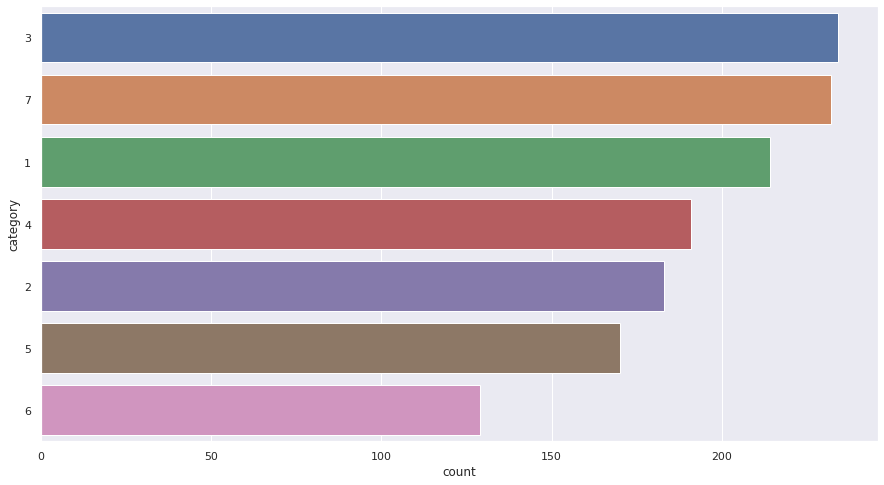

In [45]:
df_no_jabt=pd.read_csv('../data/train.csv')

sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(y='category', data=df_no_jabt, order=df_no_jabt['category'].value_counts().index)

In [46]:
df_no_jabt['category'].value_counts()

3    234
7    232
1    214
4    191
2    183
5    170
6    129
Name: category, dtype: int64

## 일본어 역번역 미리 돌려둔 csv가져오기(pororo 1539개는 조금 오래 걸림)

In [47]:
ja_bt=pd.read_csv('../data/raw_data/origin_data_ja_bt.csv')

## 분포를 고려하여 90개의 `일본어 역번역` 데이터 증강(샘플링)

In [48]:
what_df=ja_bt.iloc[random.sample(list(ja_bt[ja_bt['category']==6].index),30)]
why_df=ja_bt.iloc[random.sample(list(ja_bt[ja_bt['category']==5].index),20)]
when_date_df=ja_bt.iloc[random.sample(list(ja_bt[ja_bt['category']==2].index),30)]
who_df=ja_bt.iloc[random.sample(list(ja_bt[ja_bt['category']==4].index),10)]

In [49]:
new_noans_with_ja_bt=pd.concat([remove_noanswer_df,what_df,why_df,when_date_df,who_df])
new_noans_with_ja_bt.index=[i for i in range(len(new_noans_with_ja_bt))]
new_noans_with_ja_bt.to_csv("../data/train.csv", mode='w', index=False)

# 최종 시각화

In [51]:
question_mark_dict={1:'1 : When(term)',
                    2:'2 :When(date)',
                    3:'3 : Who(action)',
                    4:'4 : Who(role)',
                    5:'5 : Why(action)',
                    6:'6 : What(indicator)',
                    7:'7 : What(conference)'}

category_list=list(new_noans_with_ja_bt['category'])

for i in range(len(category_list)):
    for key in question_mark_dict.keys():
        if category_list[i]==key:
            category_list[i]=question_mark_dict[key]

new_noans_with_ja_bt['category']=category_list

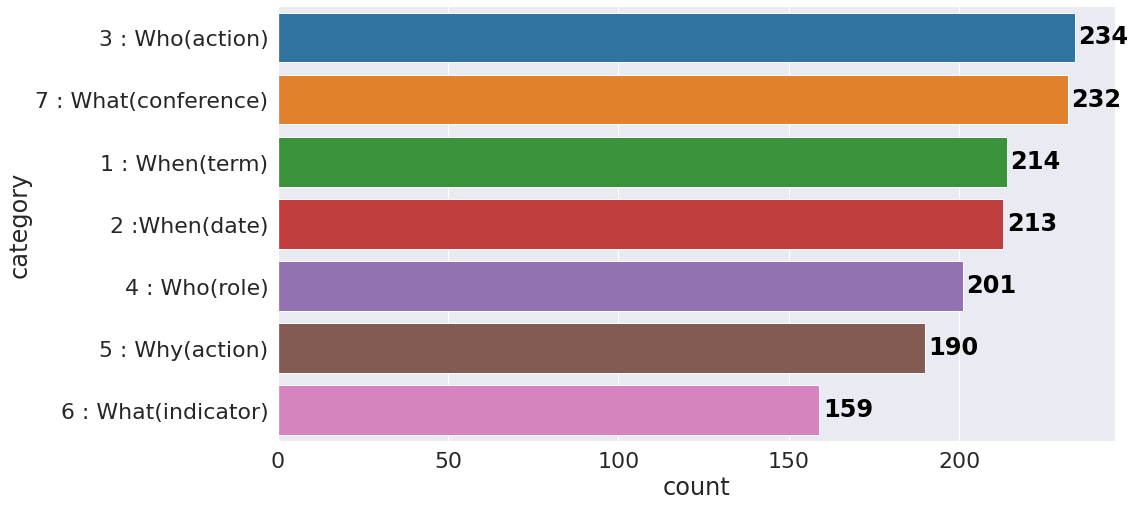

In [52]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.set(font_scale=2)
ax=sns.countplot(y='category', data=new_noans_with_ja_bt, order=new_noans_with_ja_bt['category'].value_counts().index,palette="tab10")

for i, v in enumerate(new_noans_with_ja_bt['category'].value_counts()):
    ax.text(v + 1, i + .10, str(v), color='black', fontweight='bold')
    
plt.show()